In [1]:
spark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
import matplotlib.pyplot as plt
%matplotlib inline
import json
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [3]:
spark = SparkSession.builder.appName('TwitterCovid19').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'bigdatacluster1-m'),
 ('spark.driver.appUIAddress',
  'http://bigdatacluster1-m.us-central1-a.c.even-hull-328204.internal:39473'),
 ('spark.kryoserializer.buffer.max', '2000M'),
 ('spark.app.startTime', '1637959614284'),
 ('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.history.fs.logDirectory',
  'gs://dataproc-temp-us-central1-483306255930-3hw1ksoh/7ef95c54-9c40-4f52-b485-18be0e1d8cfc/spark-job-history'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.driver.host',
  'bigdatacluster1-m.us-central1-a.c.even-hull-328204.internal'),
 ('sp

In [4]:
df = spark.read.option("multiline","true").option("header", "true").option("ignoreTrailingWhiteSpace","true").\
option("ignoreLeadingWhiteSpace", "true").option("inferSchema", "true")\
.csv("gs://bigdata_project_hksv/tweetData/*.csv")

In [5]:
df.show()

+-------------------+----------+--------+-----+--------------+----------+--------------------+
|           tweet_id|     tdate|   ttime|tlang|tcountry_place|month_year|               tweet|
+-------------------+----------+--------+-----+--------------+----------+--------------------+
|1313520869407371264|2020-10-06|16:45:53|   en|          NULL|   2020-10|Trump looked like...|
|1313520870183243777|2020-10-06|16:45:54|   en|          NULL|   2020-10|Secret Service Ag...|
|1313520870216916994|2020-10-06|16:45:54|   en|          NULL|   2020-10|                null|
|1313520870472781826|2020-10-06|16:45:54|   en|          NULL|   2020-10|                null|
|1313520870988681216|2020-10-06|16:45:54|   en|          NULL|   2020-10|                null|
|1313520872301363201|2020-10-06|16:45:54|   en|          NULL|   2020-10|Local experts fro...|
|1313520872691503106|2020-10-06|16:45:54|   en|          NULL|   2020-10|#NYC to test #tea...|
|1313520873048084481|2020-10-06|16:45:54|   en|   

In [6]:
df1 = df.dropna(thresh=1, subset=('tweet'))

In [7]:
df1 = df1.filter(df1.tlang == "en")

In [8]:
df1.show(3, truncate=False)

+-------------------+----------+--------+-----+--------------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet_id           |tdate     |ttime   |tlang|tcountry_place|month_year|tweet                                                                                                                                                                                                                                                                                  |
+-------------------+----------+--------+-----+--------------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# from pyspark.ml.feature import Tokenizer, RegexTokenizer
from sparknlp.base import *
from sparknlp.annotator import *

from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

### Preprocessing

In [10]:
from pyspark.sql.functions import when, upper

df1 = df1.withColumn('tweet1',when(upper(col("tweet")).contains('COVID19'),regexp_replace(upper(col('tweet')),'COVID19','CORONAVIRUS'))\
               .when(upper(col("tweet")).contains('COVID-19'),regexp_replace(upper(col('tweet')),'COVID-19','CORONAVIRUS'))\
               .when(upper(col("tweet")).contains('COVID'),regexp_replace(upper(col('tweet')),'COVID','CORONAVIRUS'))\
               .otherwise(df1.tweet))

df1.show(10, False)

+-------------------+----------+--------+-----+--------------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet_id           |tdate     |ttime   |tlang|tcountry_place|month_year|tweet                                                                                                                                                                                                                                                                                  |tweet1    

In [11]:
documentAssembler = DocumentAssembler().setInputCol("tweet1").setOutputCol('document')

In [12]:
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('words')

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
normalizer = Normalizer() \
    .setInputCols(["words"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])

In [15]:
stemmer = Stemmer() \
    .setInputCols(["normalized"]) \
    .setOutputCol("stem")

In [18]:
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [19]:
stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("lemmatized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)\
      .setStopWords(['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself',\
                      'yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself',\
                      'they','them','their','theirs','themselves','what','which','whom','this','that','these',\
                      'those','is','are','was','were','be','been','being','have','has','had','having','do',\
                      'does','did','doing','a','an','the','and','but','if','or','because','as','until','while',\
                      'of','at','by','for','with','about','against','between','into','through','during','before',\
                      'after','above','below','to','from','in','out','on','off','over','under','again','further',\
                      'then','once','here','there','when','where','why','how','all','any','both','each','few',\
                      'more','most','other','some','such','nor','only','own','same','so','than','too','very','s',\
                      't','can','will','just','don','should','now',"i'll","you'll","he'll","she'll","we'll",\
                      "they'll","i'd","you'd","he'd","she'd","we'd","they'd","i'm","you're","he's","she's","it's",\
                      "we're","they're","i've","we've","you've","they've","isn't","aren't","wasn't","weren't",\
                      "haven't","hasn't","hadn't","don't","doesn't","didn't","won't","wouldn't","shan't",\
                      "shouldn't","mustn't","can't","couldn't",'cannot','could',"here's","how's","let's",'ought',\
                      "that's","there's","what's","when's","where's","why's",'would','no','not','get','via','amp']) 

In [20]:
stopwords_cleaner.getStopWords()

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'nor',
 'only',
 'own',
 'same',
 'so',
 'than'

In [21]:
pos_tagger = PerceptronModel.pretrained('pos_anc') \
     .setInputCols(['lemmatized']) \
     .setOutputCol('pos')

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[ | ]pos_anc download started this may take some time.
Approximate size to download 3.9 MB
Download done! Loading the resource.


[ / ]

[OK!]


In [22]:
chunker = Chunker() \
     .setInputCols(['pos']) \
     .setOutputCol('ngrams')

In [23]:
finisher = Finisher() \
     .setInputCols(['cleanTokens'])

In [24]:
nlpPipeline = Pipeline(stages=[
    documentAssembler,
    tokenizer,
    normalizer,
    stemmer,
    lemmatizer,
    stopwords_cleaner,
#     pos_tagger,
#     chunker,
    finisher
 ])
pipelineModel = nlpPipeline.fit(df1).transform(df1)


In [25]:
pipelineModel.show(5, False)

+-------------------+----------+--------+-----+--------------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet_id           |tdate     |ttime   |tlang|tcountry_place|month_year|tweet                                                          

In [26]:
pipelineModel.select('finished_cleanTokens').take(5)

[Row(finished_cleanTokens=['trump', 'look', 'like', 'man', 'try', 'contain', 'disdain', 'shouldve', 'feel', 'great', 'end', 'scene', 'mission', 'accomplish', 'triumphant', 'balcony', 'tumultuous', 'unexpected', 'medical', 'news', 'walter', 'reed', 'relate', 'coronavirus', 'course', 'httpstconcecacot93']),
 Row(finished_cleanTokens=['secret', 'service', 'agent', 'turn', 'trump', 'walter', 'reed', 'joyride', 'put', 'risk', 'perez', 'hilton', 'smartnews', 'httpstcovfgxjiuaql']),
 Row(finished_cleanTokens=['local', 'expert', 'regence', 'oregon', 'health', 'authority', 'discuss', 'intersection', 'opioid', 'epidemic', 'coronavirus', 'katutv', 'virtual', 'town', 'hall', 'httpstcoxduwuvoei0']),
 Row(finished_cleanTokens=['nyc', 'test', 'teacher', 'student', 'coronavirus', 'random', 'start', 'friday', 'httpstcowalbh5h5fp']),
 Row(finished_cleanTokens=['lewis', 'bunting', 'deny', 'test', 'positive', 'dart', 'wgp20', 'httpstcotitwcthqx3'])]

In [ ]:
from pyspark.ml.feature import CountVectorizer

tfizer = CountVectorizer(inputCol='finished_cleanTokens',
                         outputCol='tf_features')
tf_model = tfizer.fit(pipelineModel)
tf_result = tf_model.transform(pipelineModel)

In [28]:
tf_result.select("finished_cleanTokens","tf_features").show(3, False)

21/11/27 00:50:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|finished_cleanTokens                                                                                                                                                                                                              |tf_features                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import IDF

idfizer = IDF(inputCol='tf_features', 
              outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

21/11/27 00:58:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.3 MiB
21/11/27 04:37:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.3 MiB


In [30]:
tfidf_result.select("finished_cleanTokens","tf_features","tf_idf_features").show(3, False)

21/11/27 04:51:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 7.3 MiB


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.clustering import LDA

num_topics = 7
max_iter = 12

lda = LDA(k=num_topics, 
          maxIter=max_iter, 
          featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

21/11/27 04:51:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 7.3 MiB
21/11/27 08:26:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 7.3 MiB
21/11/27 08:26:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 7.3 MiB
21/11/27 08:26:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 35.3 MiB
21/11/27 08:41:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 49.3 MiB
21/11/27 08:41:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 7.3 MiB
21/11/27 08:41:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 35.3 MiB
21/11/27 08:50:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 49.3 MiB
21/11/27 08:50:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bina

In [32]:
vocab = tf_model.vocabulary

def get_words(token_list):
    return [vocab[token_id] for token_id in token_list]
udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))

In [33]:
num_top_words = 7
topics = lda_model\
     .describeTopics(num_top_words)\
     .withColumn('topicWords', udf_to_words(F.col('termIndices')))
# topics.show(3, False)
topics.select('termIndices','topic', 'topicWords', 'termWeights').show(truncate=False)

+--------------------------+-----+---------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|termIndices               |topic|topicWords                                                     |termWeights                                                                                                                                                    |
+--------------------------+-----+---------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1, 6, 3, 22, 4, 0, 103]  |0    |[case, death, new, report, test, coronavirus, total]           |[0.013208303415359751, 0.009172768415056175, 0.008185246221107794, 0.00509223727495514, 0.0048652881860779314, 0.004515126767

In [34]:
from pyspark.sql import Row, column
from pyspark.sql.functions import col

topics_words = topics.rdd.map(lambda row: row['termIndices'])\
.map(lambda idx_list: [vocab[idx] for idx in idx_list]).collect()

topics_weights = topics.rdd.map(lambda x:x[2]).collect()
topics_words, topics_weights

([['case', 'death', 'new', 'report', 'test', 'coronavirus', 'total'],
  ['mask', 'coronavirus', 'wear', 'trump', 'say', 'news', 'pandemic'],
  ['people',
   'trump',
   'realdonaldtrump',
   'die',
   'dont',
   'coronavirus',
   'death'],
  ['coronavirus', 'vaccine', 'news', 'trump', 'say', 'china', 'pandemic'],
  ['coronavirus', 'pandemic', 'who', 'business', 'new', 'test', 'know'],
  ['vaccine', 'work', 'coronavirus', 'pandemic', 'help', 'health', 'home'],
  ['test',
   'coronavirus',
   'bill',
   'pandemic',
   'relief',
   'vaccine',
   'positive']],
 [[0.013208303415359751,
   0.009172768415056175,
   0.008185246221107794,
   0.00509223727495514,
   0.0048652881860779314,
   0.004515126767785612,
   0.004494721415554428],
  [0.004045263836303854,
   0.003988658697732661,
   0.0032486187982233793,
   0.0032467750987469415,
   0.002490825605187733,
   0.00239837348723286,
   0.0023888422451830878],
  [0.0053407221608656455,
   0.005281139414800893,
   0.004808901918667832,
   0.00

In [35]:
res = {}
sub_list = []

for i in range(len(topics_weights)):
    for j in range(len(topics_weights[i])):
#         print(topics_words[i][j])
        res[topics_words[i][j]] = topics_weights[i][j]        
    sub_list.append(res)
    res = {}

# res
sub_list

[{'case': 0.013208303415359751,
  'death': 0.009172768415056175,
  'new': 0.008185246221107794,
  'report': 0.00509223727495514,
  'test': 0.0048652881860779314,
  'coronavirus': 0.004515126767785612,
  'total': 0.004494721415554428},
 {'mask': 0.004045263836303854,
  'coronavirus': 0.003988658697732661,
  'wear': 0.0032486187982233793,
  'trump': 0.0032467750987469415,
  'say': 0.002490825605187733,
  'news': 0.00239837348723286,
  'pandemic': 0.0023888422451830878},
 {'people': 0.0053407221608656455,
  'trump': 0.005281139414800893,
  'realdonaldtrump': 0.004808901918667832,
  'die': 0.004285231864164675,
  'dont': 0.003774456978026103,
  'coronavirus': 0.0034785018591742757,
  'death': 0.0034266660632142703},
 {'coronavirus': 0.004098666421777183,
  'vaccine': 0.003504892954588068,
  'news': 0.0032096516505358596,
  'trump': 0.0025928486035320048,
  'say': 0.0025864229973686756,
  'china': 0.00244914486641644,
  'pandemic': 0.0023870523099885793},
 {'coronavirus': 0.0039696556693671

In [ ]:
# for idx, topic in enumerate(topics_words):
#     print("topic: {}".format(idx))
#     print("*"*25)
#     for word in topic:
#         print(word), print()
#     print("*"*25)

In [36]:
import pandas as pd
pd_df = pd.DataFrame(sub_list)
pd_df_transposed = pd_df.transpose()
pd_df.fillna(0, inplace=True)
pd_df

,case,death,new,report,test,coronavirus,total,mask,wear,trump,...,who,business,know,work,help,health,home,bill,relief,positive
0,0.013208,0.009173,0.008185,0.005092,0.004865,0.004515,0.004495,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.003989,0.000000,0.004045,0.003249,0.003247,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.003427,0.000000,0.000000,0.000000,0.003479,0.000000,0.000000,0.000000,0.005281,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.004099,0.000000,0.000000,0.000000,0.002593,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.002243,0.000000,0.002164,0.003970,0.000000,0.000000,0.000000,0.000000,...,0.002523,0.00248,0.002164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.003858,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.003936,0.003636,0.003067,0.002793,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.003956,0.003940,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002544,0.002464,0.002241


In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import numpy as np

In [41]:
len(pd_df.columns)

29

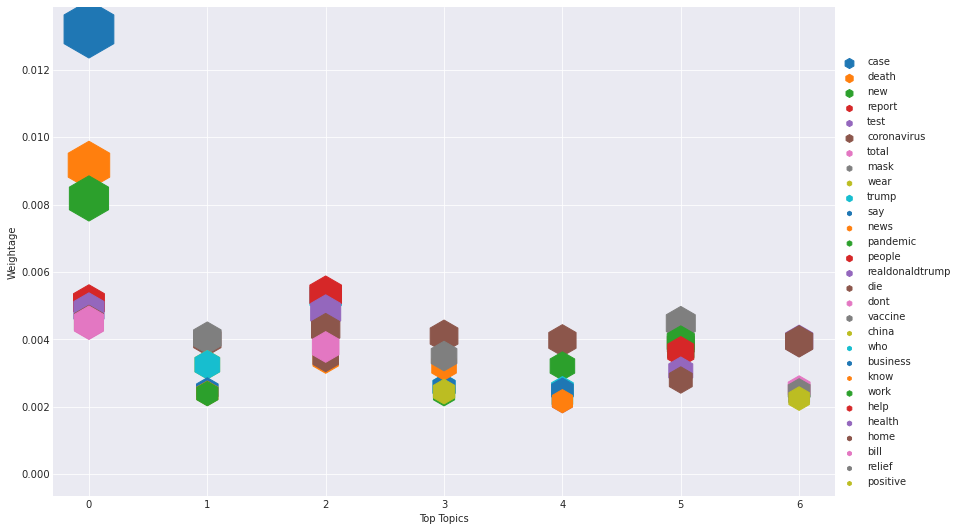

In [42]:
fig = plt.figure(figsize = (14,9))
ax = fig.add_subplot(111)

labels = [pd_df.columns[i] for i in range(len(pd_df.columns))]
for i in range(len(pd_df.columns)):
    plt.scatter(pd_df.index,  pd_df.iloc[:,i], s = pd_df.iloc[:,i]*250000, label = pd_df.columns[i], marker="h")

plt.xlabel("Top Topics")
plt.ylabel("Weightage")
plt.legend(loc = "lower right", markerscale = 0.25, bbox_to_anchor=(1.16, 0))

plt.style.use("seaborn-darkgrid")

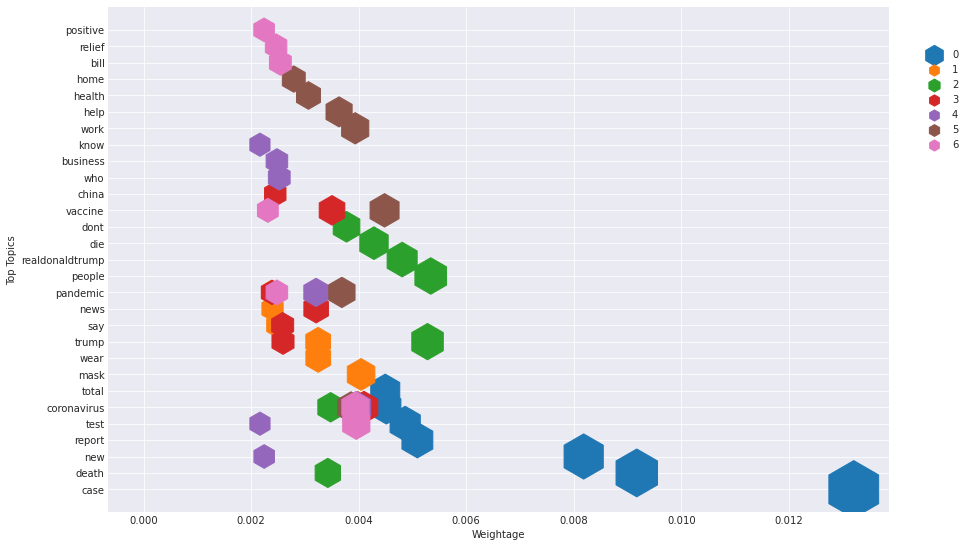

In [43]:
fig = plt.figure(figsize = (14,9))
ax = fig.add_subplot(111)

labels = [pd_df_transposed.columns[i] for i in range(len(pd_df_transposed.columns))]
for i in range(len(pd_df_transposed.columns)):
#     plt.scatter(pd_df_transposed.index, pd_df_transposed.iloc[:,i], s = pd_df_transposed.iloc[:,i]*250000, \
#                 label = pd_df_transposed.columns[i], marker="h")
    plt.scatter(pd_df_transposed.iloc[:,i], pd_df_transposed.index, s = pd_df_transposed.iloc[:,i]*250000, \
                label = pd_df_transposed.columns[i], marker="h")
plt.xlabel("Weightage")
plt.ylabel("Top Topics")
# plt.xticks(fontsize = 13)
# plt.yticks(fontsize = 13)

plt.legend(loc = "lower right", bbox_to_anchor=(1.1, 0.7), markerscale = 0.5)
fig.subplots_adjust(bottom=0.1)
plt.style.use("tableau-colorblind10")

In [46]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(30,30))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [59]:
# show_wordcloud(pdf['tweet'], title = 'Prevalent Words in Tweets')

word_list = pd_df.columns.to_list()
word_str = (" ").join(word_list)
word_str

'case death new report test coronavirus total mask wear trump say news pandemic people realdonaldtrump die dont vaccine china who business know work help health home bill relief positive'

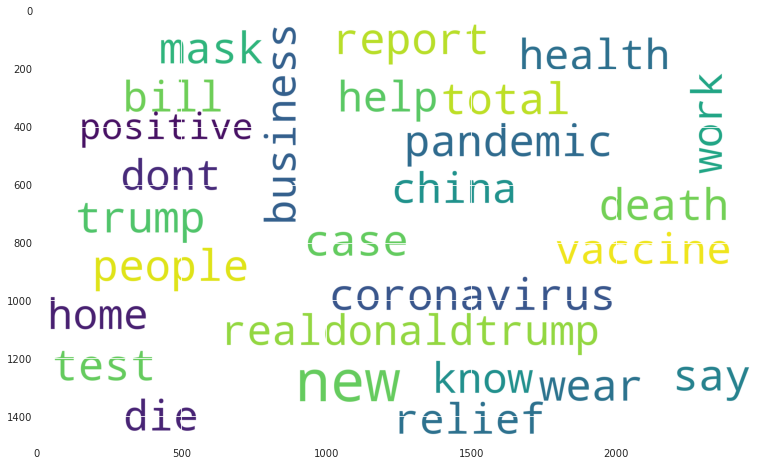

In [71]:
wordcloud = WordCloud(width = 500, height = 300, max_font_size=40, scale = 5, random_state=1,\
                      background_color='white').generate(word_str)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()